# Predicting Distance (Linear Regression)

- Here I am predicting the continuous distance of how far a batted ball travels as a function of input variables (e.g., exit velocity and launch angle), then using PyMC3 for regression

- PyMC3 helps me estimate credible intervals for the expected distance, taking into account the uncertainty in the model parameters (e.g., coefficients) and the variability in the data

- I am quantifying the uncertainty in the distance predictions and understanding how changes in input variables relate to changes in distance.

**Installation**

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

**Data**

In [2]:
# Hrs from the 2022 MLB season (exit velocity and launch angle)
exit_velocity = np.array([98.3, 105.3, 101.3, 106.9, 104.8, 108.9, 111.9, 112.5, 103.8, 103.7, 112.5, 108.4, 104.3, 101.3, 100.1, 109.2, 91.8, 102.4, 106.6, 103.4])
launch_angle = np.array([26.0, 36.0, 39.0, 32.0, 37.0, 23.0, 23.0, 24.0, 23.0, 27.0, 31.0, 25.0, 25.0, 28.0, 27.0, 22.0, 36.0, 31.0, 38.0, 27.0])
distance = np.array([346.0, 395.0, 359.0, 378.0, 408.0, 382.0, 439.0, 424.0, 335.0, 378.0, 429.0, 417.0, 383.0, 384.0, 379.0, 405.0, 360.0, 387.0, 386.0, 386.0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_launch_angle, beta_exit_velocity, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 14 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


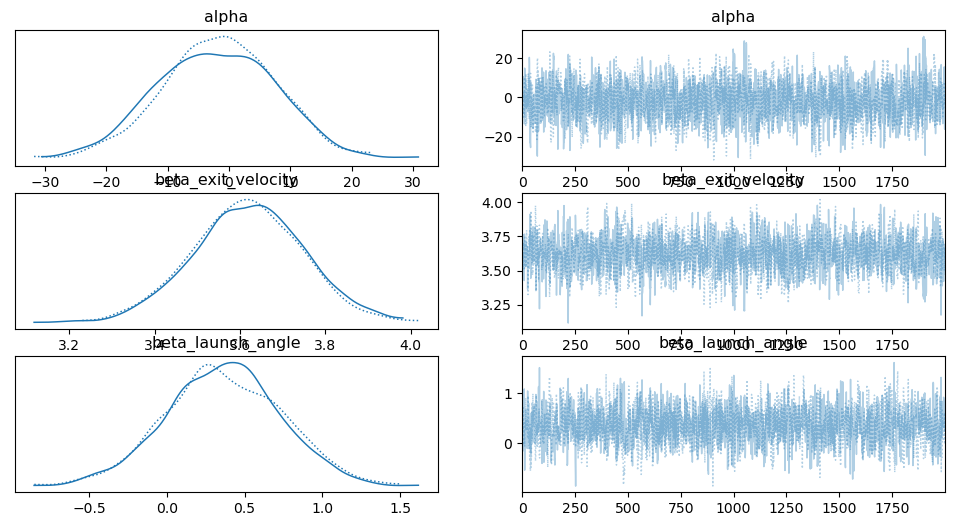

Got error No model on context stack. trying to find log_likelihood in translation.


                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha              -1.860  9.624 -20.249   15.362      0.224    0.179   
beta_exit_velocity  3.618  0.130   3.360    3.849      0.003    0.002   
beta_launch_angle   0.365  0.368  -0.300    1.080      0.010    0.007   

                    ess_bulk  ess_tail  r_hat  
alpha                 1845.0    1695.0    1.0  
beta_exit_velocity    1471.0    1485.0    1.0  
beta_launch_angle     1468.0    1667.0    1.0  


In [3]:
# Define model
with pm.Model() as baseball_model:  # Define the model within the context
    # Define model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_exit_velocity = pm.Normal('beta_exit_velocity', mu=0, sd=10)
    beta_launch_angle = pm.Normal('beta_launch_angle', mu=0, sd=10)
    
    # Expected distance as a linear function of exit velocity and launch angle
    mu = alpha + beta_exit_velocity * exit_velocity + beta_launch_angle * launch_angle
    
    # Likelihood of observing the data
    observed_distance = pm.Normal('observed_distance', mu=mu, sd=10, observed=distance)

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000, cores=2)
    
pm.traceplot(trace)
plt.show()

# Summarize the posterior distribution
summary = pm.summary(trace)
print(summary)

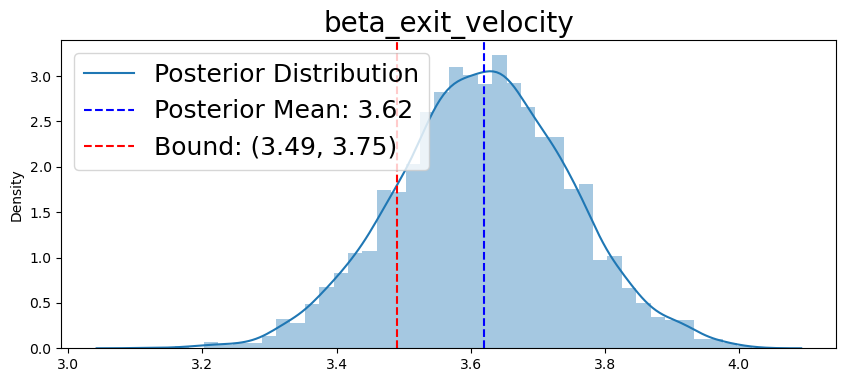

In [4]:
plt.figure(figsize=(10, 4))
vals = trace['beta_exit_velocity']
mean, lower, upper = round(vals.mean(), 2), round(vals.mean() - vals.std(), 2), round(vals.mean() + vals.std(), 2)
sns.distplot(vals, kde_kws={'label': 'Posterior Distribution'})

plt.axvline(mean, color='b', linestyle='--', label=f'Posterior Mean: {mean}')
plt.axvline(lower, color='r', linestyle='--', label=f'Bound: ({lower}, {upper})')

plt.title('beta_exit_velocity', fontsize=20)  # Replace <true_value_here> with the actual true value

plt.legend(fontsize=18)

plt.show()

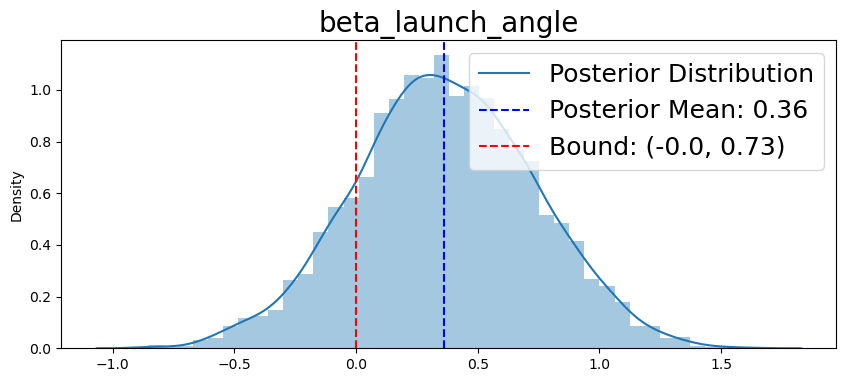

In [5]:
plt.figure(figsize=(10, 4))
vals = trace['beta_launch_angle']
mean, lower, upper = round(vals.mean(), 2), round(vals.mean() - vals.std(), 2), round(vals.mean() + vals.std(), 2)
sns.distplot(vals, kde_kws={'label': 'Posterior Distribution'})

plt.axvline(mean, color='b', linestyle='--', label=f'Posterior Mean: {mean}')
plt.axvline(lower, color='r', linestyle='--', label=f'Bound: ({lower}, {upper})')

plt.title('beta_launch_angle', fontsize=20)  # Replace <true_value_here> with the actual true value

plt.legend(fontsize=18)

plt.show()

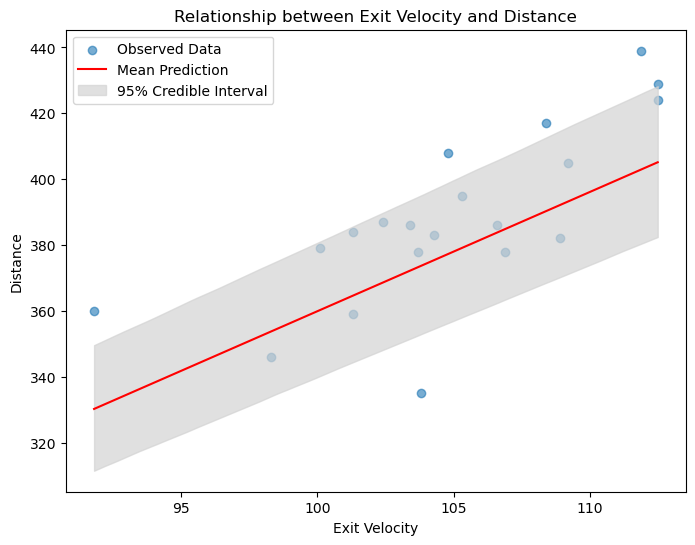

In [6]:
alpha_samples = trace['alpha']
beta_exit_velocity_samples = trace['beta_exit_velocity']

# Create a range of values for exit velocity
exit_velocity_range = np.linspace(exit_velocity.min(), exit_velocity.max(), 100)

# Calculate predicted distance for each value of exit velocity
predicted_distance = alpha_samples[:, np.newaxis] + beta_exit_velocity_samples[:, np.newaxis] * exit_velocity_range

# Plot the relationship between observed distance and exit velocity
plt.figure(figsize=(8, 6))
plt.scatter(exit_velocity, distance, label='Observed Data', alpha=0.6)
plt.plot(exit_velocity_range, np.mean(predicted_distance, axis=0), color='red', label='Mean Prediction')
plt.fill_between(exit_velocity_range, np.percentile(predicted_distance, 2.5, axis=0), np.percentile(predicted_distance, 97.5, axis=0), color='lightgray', label='95% Credible Interval', alpha=0.7)
plt.xlabel('Exit Velocity')
plt.ylabel('Distance')
plt.title('Relationship between Exit Velocity and Distance')
plt.legend()

plt.show()

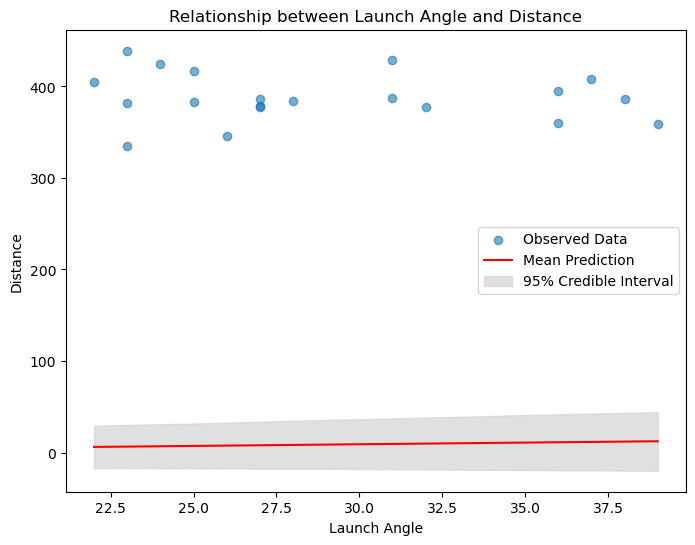

In [7]:
# Extract the trace samples for alpha and beta_launch_angle
alpha_samples = trace['alpha']
beta_launch_angle_samples = trace['beta_launch_angle']

# Create a range of values for launch angle
launch_angle_range = np.linspace(launch_angle.min(), launch_angle.max(), 100)

# Calculate predicted distance for each value of launch angle
predicted_distance = alpha_samples[:, np.newaxis] + beta_launch_angle_samples[:, np.newaxis] * launch_angle_range

# Plot the relationship between observed distance and launch angle
plt.figure(figsize=(8, 6))
plt.scatter(launch_angle, distance, label='Observed Data', alpha=0.6)
plt.plot(launch_angle_range, np.mean(predicted_distance, axis=0), color='red', label='Mean Prediction')
plt.fill_between(launch_angle_range, np.percentile(predicted_distance, 2.5, axis=0), np.percentile(predicted_distance, 97.5, axis=0), color='lightgray', label='95% Credible Interval', alpha=0.7)
plt.xlabel('Launch Angle')
plt.ylabel('Distance')
plt.title('Relationship between Launch Angle and Distance')
plt.legend()

plt.show()

# Non Linear Regression

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, beta_launch_angle, beta_exit_velocity, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 23 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


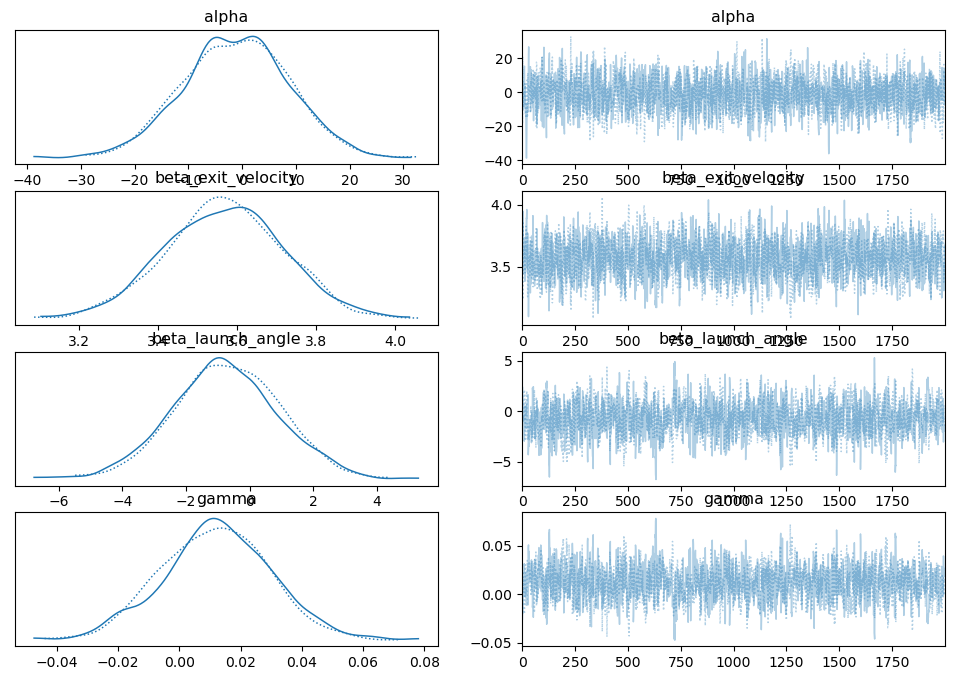

In [8]:
# Define a nonlinear function for the relationship
def nonlinear_function(exit_velocity, launch_angle, alpha, beta_exit_velocity, beta_launch_angle, gamma):
    return alpha + beta_exit_velocity * exit_velocity + beta_launch_angle * launch_angle + gamma * exit_velocity * launch_angle

# Define model
with pm.Model() as nonlinear_regression_model:
    # Define model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_exit_velocity = pm.Normal('beta_exit_velocity', mu=0, sd=10)
    beta_launch_angle = pm.Normal('beta_launch_angle', mu=0, sd=10)
    gamma = pm.Normal('gamma', mu=0, sd=10)
    
    # Expected distance as a nonlinear function of exit velocity and launch angle
    mu = nonlinear_function(exit_velocity, launch_angle, alpha, beta_exit_velocity, beta_launch_angle, gamma)
    
    # Likelihood of observing the data
    observed_distance = pm.Normal('observed_distance', mu=mu, sd=10, observed=distance)

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000, cores=2)

# Plot the posterior distribution of parameters
pm.traceplot(trace)
plt.show()

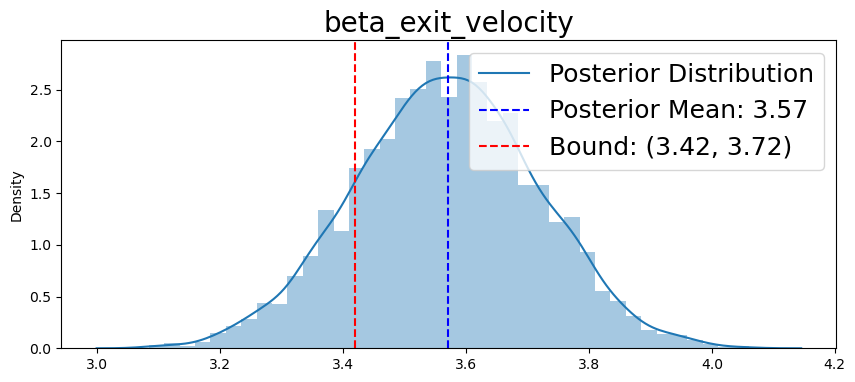

In [9]:
plt.figure(figsize=(10, 4))
vals = trace['beta_exit_velocity']
mean, lower, upper = round(vals.mean(), 2), round(vals.mean() - vals.std(), 2), round(vals.mean() + vals.std(), 2)
sns.distplot(vals, kde_kws={'label': 'Posterior Distribution'})

plt.axvline(mean, color='b', linestyle='--', label=f'Posterior Mean: {mean}')
plt.axvline(lower, color='r', linestyle='--', label=f'Bound: ({lower}, {upper})')

plt.title('beta_exit_velocity', fontsize=20)  # Replace <true_value_here> with the actual true value

plt.legend(fontsize=18)

plt.show()

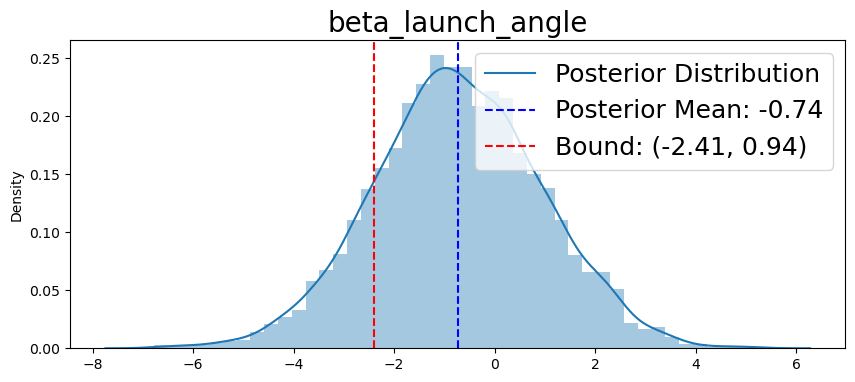

In [10]:
plt.figure(figsize=(10, 4))
vals = trace['beta_launch_angle']
mean, lower, upper = round(vals.mean(), 2), round(vals.mean() - vals.std(), 2), round(vals.mean() + vals.std(), 2)
sns.distplot(vals, kde_kws={'label': 'Posterior Distribution'})

plt.axvline(mean, color='b', linestyle='--', label=f'Posterior Mean: {mean}')
plt.axvline(lower, color='r', linestyle='--', label=f'Bound: ({lower}, {upper})')

plt.title('beta_launch_angle', fontsize=20)  # Replace <true_value_here> with the actual true value

plt.legend(fontsize=18)

plt.show()

# Gaussian Process

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [signal_variance, length_scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


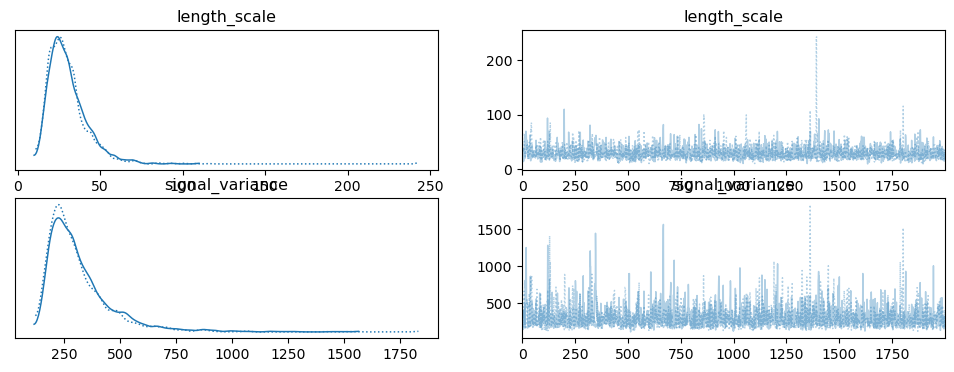

Got error No model on context stack. trying to find log_likelihood in translation.


                    mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
length_scale      30.074   12.484   13.202   51.922      0.311    0.220   
signal_variance  313.419  148.004  133.663  567.125      3.670    2.596   

                 ess_bulk  ess_tail  r_hat  
length_scale       1612.0    1535.0    1.0  
signal_variance    1941.0    1877.0    1.0  


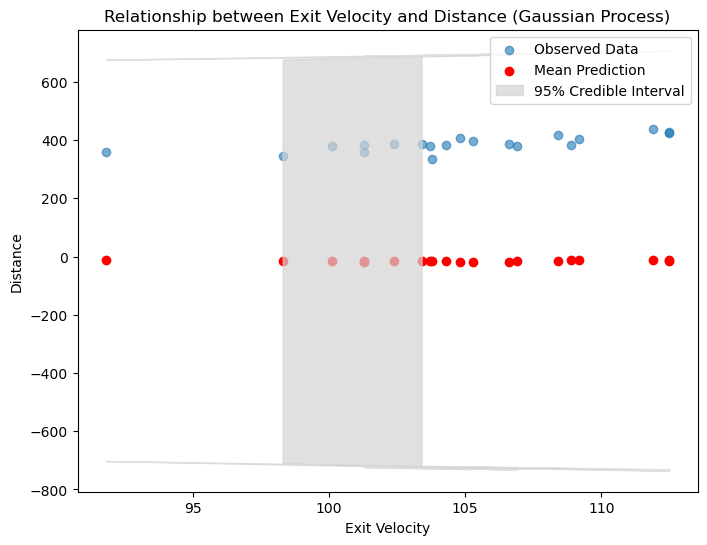

In [11]:
# Define a custom kernel for Gaussian Process
with pm.Model() as gp_model:
    # Define priors for the hyperparameters of the kernel
    length_scale = pm.HalfCauchy('length_scale', beta=5)
    signal_variance = pm.HalfCauchy('signal_variance', beta=5)
    
    # Define the Gaussian Process with the custom kernel
    gp = pm.gp.Marginal(cov_func=signal_variance ** 2 * pm.gp.cov.ExpQuad(2, ls=length_scale))
    
    # Define the GP likelihood
    y_ = gp.marginal_likelihood('y', X=np.column_stack((exit_velocity, launch_angle)), y=distance, noise=10)
    
    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000, cores=2)

# Plot the posterior distribution of the Gaussian Process
pm.traceplot(trace)
plt.show()

# Now let's make predictions using the GP
X_new = np.column_stack((exit_velocity, launch_angle))

# Use the GP to predict the mean and standard deviation
with gp_model:
    f_pred = gp.conditional("f_pred", X_new)
    y_pred = pm.sample_posterior_predictive(trace, samples=1000)


# Extract the mean and standard deviation predictions
mean_prediction = np.mean(y_pred['y'], axis=0)
std_prediction = np.std(y_pred['y'], axis=0)


# Summarize the posterior distribution
summary = pm.summary(trace)
print(summary)

# Plot the relationship between observed distance and exit velocity
plt.figure(figsize=(8, 6))
plt.scatter(exit_velocity, distance, label='Observed Data', alpha=0.6)

# Plot the GP predictions
plt.scatter(exit_velocity, mean_prediction, color='red', label='Mean Prediction')
plt.fill_between(exit_velocity, mean_prediction - 2 * std_prediction, mean_prediction + 2 * std_prediction, color='lightgray', label='95% Credible Interval', alpha=0.7)

plt.xlabel('Exit Velocity')
plt.ylabel('Distance')
plt.title('Relationship between Exit Velocity and Distance (Gaussian Process)')
plt.legend()

plt.show()
